In [23]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator, DayLocator, MONDAY
import seaborn as sns

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

from scipy import stats
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

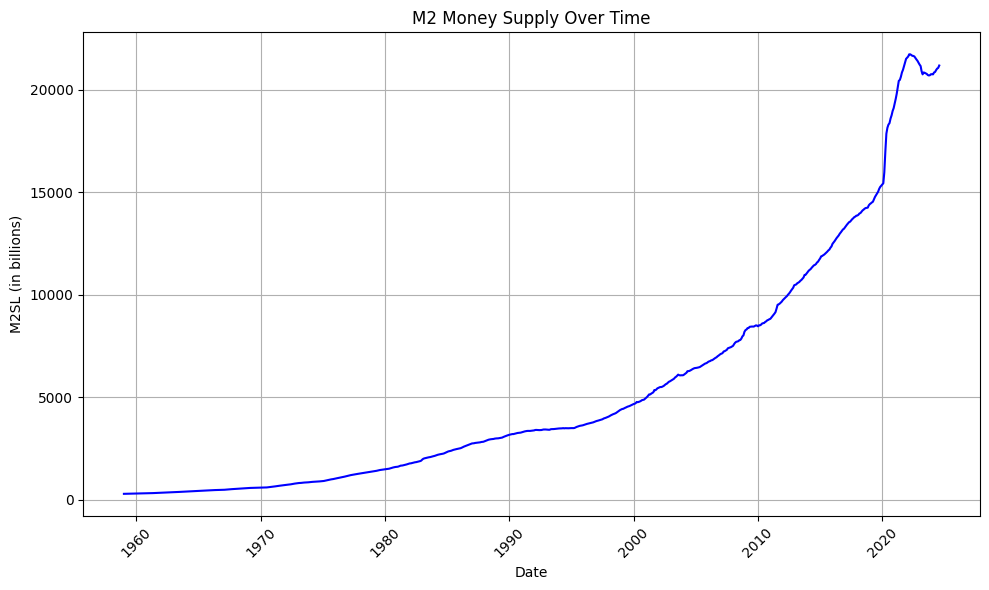

In [24]:
#Get the data and plot it
data = pd.read_csv("data/M2SL.csv")
data['DATE'] = pd.to_datetime(data['DATE'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['M2SL'], linestyle='-', color='b')
plt.title('M2 Money Supply Over Time')
plt.xlabel('Date')
plt.ylabel('M2SL (in billions)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
def pandas_candlestick_ohlc(dat, stick="day", otherseries=None, txt=""):
    """
    Japanese candlestick chart showing OHLC prices for a specified time period
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
    :param txt: Title text for the candlestick chart

    :returns: a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    sns.set(rc={'figure.figsize':(20, 10)})
    sns.set_style("whitegrid")  # Apply seaborn whitegrid style to the plots 

    transdat = dat.loc[:, ["Open", "High", "Low", "Close"]].copy()

    if type(stick) == str and stick in ["day", "week", "month", "year"]:
        if stick != "day":
            if stick == "week":
                transdat['period'] = pd.to_datetime(transdat.index).map(lambda x: x.strftime('%Y-%U'))
            elif stick == "month":
                transdat['period'] = pd.to_datetime(transdat.index).map(lambda x: x.strftime('%Y-%m'))
            elif stick == "year":
                transdat['period'] = pd.to_datetime(transdat.index).map(lambda x: x.strftime('%Y'))
            
            grouped = transdat.groupby('period')
            plotdat = pd.DataFrame([{
                "Open": group.iloc[0]["Open"],
                "High": max(group["High"]),
                "Low": min(group["Low"]),
                "Close": group.iloc[-1]["Close"]
            } for _, group in grouped], index=pd.to_datetime([period for period, _ in grouped]))
        else:
            plotdat = transdat
            plotdat['period'] = pd.to_datetime(plotdat.index)
    elif type(stick) == int and stick >= 1:
        transdat['period'] = np.floor(np.arange(len(transdat)) / stick)
        grouped = transdat.groupby('period')
        plotdat = pd.DataFrame([{
            "Open": group.iloc[0]["Open"],
            "High": max(group["High"]),
            "Low": min(group["Low"]),
            "Close": group.iloc[-1]["Close"]
        } for _, group in grouped], index=[group.index[0] for _, group in grouped])
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')

    plotdat['date_num'] = date2num(plotdat.index.to_pydatetime())

    fig, ax = plt.subplots()
    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    sns.set(rc={'figure.figsize':(20, 10)})
    candlestick_ohlc(ax, plotdat[['date_num', 'Open', 'High', 'Low', 'Close']].values, width=0.6/(24*60), colorup='g', colordown='r')

    if otherseries is not None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        for series in otherseries:
            dat[series].plot(ax=ax, lw=1.3)

    plt.title(f"Candlestick chart of HSBA.L OHLC stock prices from 01 Jan 2014 - 31 Dec 2023", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
    candlestick_ohlc(ax, plotdat[['date_num', 'Open', 'High', 'Low', 'Close']].values, width=20, colorup='g', colordown='r')

    plt.show()

In [26]:
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="5y")
print(sp500.head())

                                  Open         High          Low        Close  \
Date                                                                            
2019-10-18 00:00:00-04:00  2996.840088  3000.000000  2976.310059  2986.199951   
2019-10-21 00:00:00-04:00  2996.479980  3007.330078  2995.350098  3006.719971   
2019-10-22 00:00:00-04:00  3010.729980  3014.570068  2995.040039  2995.989990   
2019-10-23 00:00:00-04:00  2994.010010  3004.780029  2991.209961  3004.520020   
2019-10-24 00:00:00-04:00  3014.780029  3016.070068  3000.419922  3010.290039   

                               Volume  Dividends  Stock Splits  
Date                                                            
2019-10-18 00:00:00-04:00  3268970000        0.0           0.0  
2019-10-21 00:00:00-04:00  3271960000        0.0           0.0  
2019-10-22 00:00:00-04:00  3527540000        0.0           0.0  
2019-10-23 00:00:00-04:00  3413600000        0.0           0.0  
2019-10-24 00:00:00-04:00  3696510000     

[*********************100%***********************]  1 of 1 completed

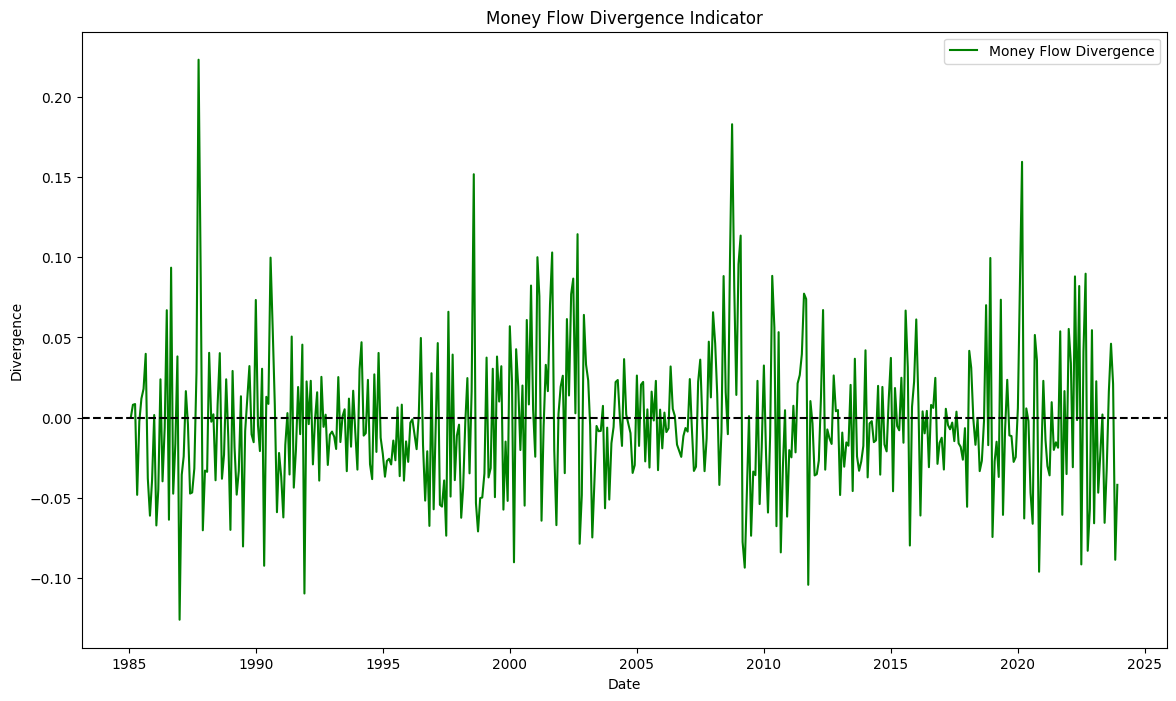

Buy Signals:           DATE  Growth Divergence
330 1986-07-01           0.066975
332 1986-09-01           0.093487
345 1987-10-01           0.223096
346 1987-11-01           0.086805
372 1990-01-01           0.073353
379 1990-08-01           0.099741
380 1990-09-01           0.055071
389 1991-06-01           0.050555
463 1997-08-01           0.066003
475 1998-08-01           0.151720
492 2000-01-01           0.056984
500 2000-09-01           0.060893
502 2000-11-01           0.082348
505 2001-02-01           0.100008
506 2001-03-01           0.075752
511 2001-08-01           0.070604
512 2001-09-01           0.102956
519 2002-04-01           0.061454
521 2002-06-01           0.076983
522 2002-07-01           0.086685
524 2002-09-01           0.114357
527 2002-12-01           0.064054
588 2008-01-01           0.065701
593 2008-06-01           0.088258
596 2008-09-01           0.099687
597 2008-10-01           0.182886
598 2008-11-01           0.081189
600 2009-01-01           0.095618
6

In [27]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Step 1: Get the data

# Download S&P 500 data using yfinance
sp500 = yf.download('^GSPC', start='1970-01-01', end='2024-01-01', interval='1mo')

m2_data = pd.read_csv('data/M2SL.csv', parse_dates=['DATE'])

# Calculate monthly growth rates for S&P 500
sp500['SP500 Growth'] = sp500['Adj Close'].pct_change()
m2_data['M2 Growth'] = m2_data['M2SL'].pct_change()

# Step 3: Merge the data on date
# Ensure both datasets have the same frequency and are aligned by date
merged_data = pd.merge(sp500[['Adj Close', 'SP500 Growth']], m2_data[['DATE', 'M2SL', 'M2 Growth']], left_index=True, right_on='DATE')

# Step 4: Calculate Money Flow Divergence
merged_data['Growth Divergence'] = merged_data['M2 Growth'] - merged_data['SP500 Growth']

# Step 5: Visualize the indicator
plt.figure(figsize=(14, 8))
plt.plot(merged_data['DATE'], merged_data['Growth Divergence'], label='Money Flow Divergence', color='green')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Money Flow Divergence Indicator')
plt.xlabel('Date')
plt.ylabel('Divergence')
plt.legend()
plt.show()

# Step 6: Strategy - Buy when divergence is greater than 5%
buy_signals = merged_data[merged_data['Growth Divergence'] > 0.05]
print(f"Buy Signals: {buy_signals[['DATE', 'Growth Divergence']]}")


### Starting the Money Divergence Calculations (No Calcuations on the Percent Return)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtesting on AAPL
(Timestamp('1959-02-28 00:00:00'), 'Hold')
(Timestamp('1959-03-31 00:00:00'), 'Hold')
(Timestamp('1959-04-30 00:00:00'), 'Hold')
(Timestamp('1959-05-31 00:00:00'), 'Hold')
(Timestamp('1959-06-30 00:00:00'), 'Hold')
(Timestamp('1959-07-31 00:00:00'), 'Hold')
(Timestamp('1959-08-31 00:00:00'), 'Hold')
(Timestamp('1959-09-30 00:00:00'), 'Hold')
(Timestamp('1959-10-31 00:00:00'), 'Hold')
(Timestamp('1959-11-30 00:00:00'), 'Hold')
(Timestamp('1959-12-31 00:00:00'), 'Hold')
(Timestamp('1960-01-31 00:00:00'), 'Hold')
(Timestamp('1960-02-29 00:00:00'), 'Hold')
(Timestamp('1960-03-31 00:00:00'), 'Hold')
(Timestamp('1960-04-30 00:00:00'), 'Hold')
(Timestamp('1960-05-31 00:00:00'), 'Hold')
(Timestamp('1960-06-30 00:00:00'), 'Hold')
(Timestamp('1960-07-31 00:00:00'), 'Hold')
(Timestamp('1960-08-31 00:00:00'), 'Hold')
(Timestamp('1960-09-30 00:00:00'), 'Hold')
(Timestamp('1960-10-31 00:00:00'), 'Hold')
(Timestamp('1960-11-30 00:00:00'), 'Hold')
(Timestamp('1960-12-31 00:00:00'),

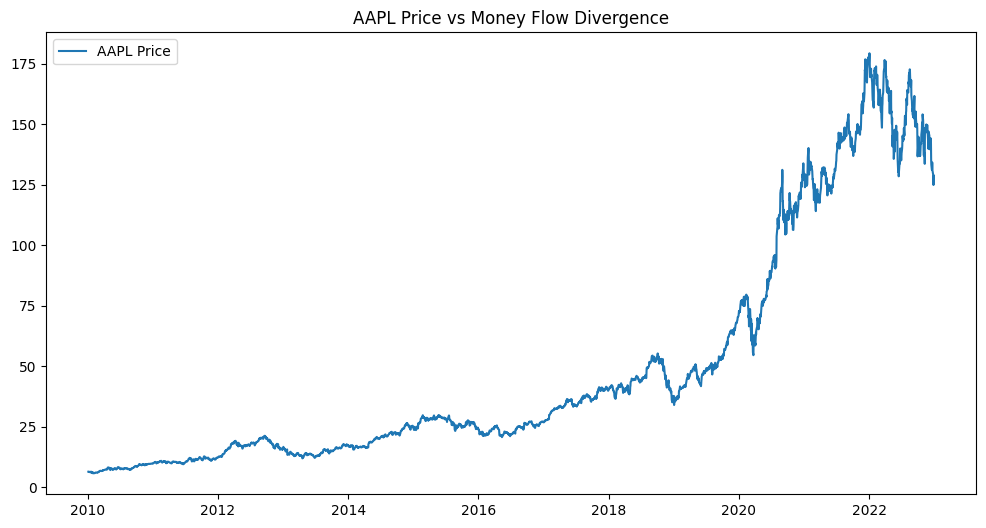

Backtesting on MSFT
(Timestamp('1959-02-28 00:00:00'), 'Hold')
(Timestamp('1959-03-31 00:00:00'), 'Hold')
(Timestamp('1959-04-30 00:00:00'), 'Hold')
(Timestamp('1959-05-31 00:00:00'), 'Hold')
(Timestamp('1959-06-30 00:00:00'), 'Hold')
(Timestamp('1959-07-31 00:00:00'), 'Hold')
(Timestamp('1959-08-31 00:00:00'), 'Hold')
(Timestamp('1959-09-30 00:00:00'), 'Hold')
(Timestamp('1959-10-31 00:00:00'), 'Hold')
(Timestamp('1959-11-30 00:00:00'), 'Hold')
(Timestamp('1959-12-31 00:00:00'), 'Hold')
(Timestamp('1960-01-31 00:00:00'), 'Hold')
(Timestamp('1960-02-29 00:00:00'), 'Hold')
(Timestamp('1960-03-31 00:00:00'), 'Hold')
(Timestamp('1960-04-30 00:00:00'), 'Hold')
(Timestamp('1960-05-31 00:00:00'), 'Hold')
(Timestamp('1960-06-30 00:00:00'), 'Hold')
(Timestamp('1960-07-31 00:00:00'), 'Hold')
(Timestamp('1960-08-31 00:00:00'), 'Hold')
(Timestamp('1960-09-30 00:00:00'), 'Hold')
(Timestamp('1960-10-31 00:00:00'), 'Hold')
(Timestamp('1960-11-30 00:00:00'), 'Hold')
(Timestamp('1960-12-31 00:00:00'),

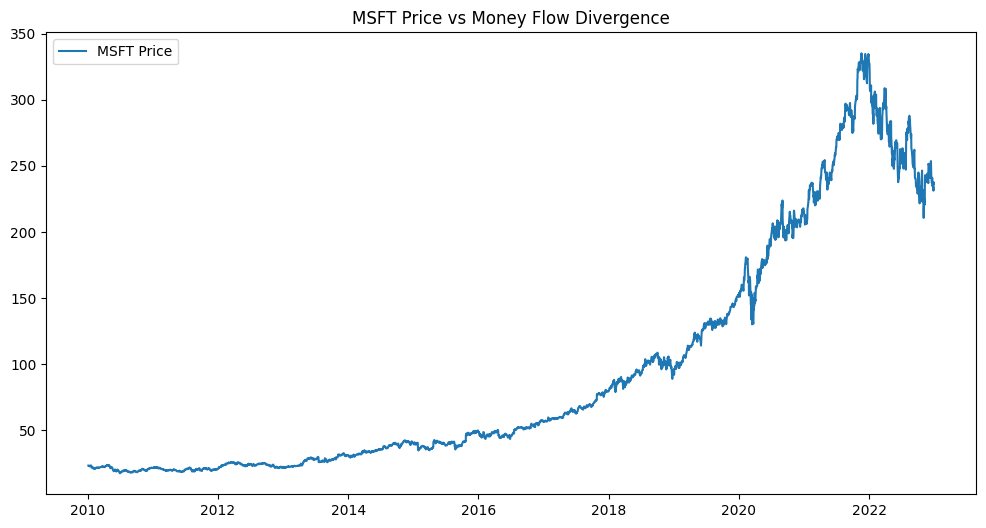

Backtesting on TSLA
(Timestamp('1959-02-28 00:00:00'), 'Hold')
(Timestamp('1959-03-31 00:00:00'), 'Hold')
(Timestamp('1959-04-30 00:00:00'), 'Hold')
(Timestamp('1959-05-31 00:00:00'), 'Hold')
(Timestamp('1959-06-30 00:00:00'), 'Hold')
(Timestamp('1959-07-31 00:00:00'), 'Hold')
(Timestamp('1959-08-31 00:00:00'), 'Hold')
(Timestamp('1959-09-30 00:00:00'), 'Hold')
(Timestamp('1959-10-31 00:00:00'), 'Hold')
(Timestamp('1959-11-30 00:00:00'), 'Hold')
(Timestamp('1959-12-31 00:00:00'), 'Hold')
(Timestamp('1960-01-31 00:00:00'), 'Hold')
(Timestamp('1960-02-29 00:00:00'), 'Hold')
(Timestamp('1960-03-31 00:00:00'), 'Hold')
(Timestamp('1960-04-30 00:00:00'), 'Hold')
(Timestamp('1960-05-31 00:00:00'), 'Hold')
(Timestamp('1960-06-30 00:00:00'), 'Hold')
(Timestamp('1960-07-31 00:00:00'), 'Hold')
(Timestamp('1960-08-31 00:00:00'), 'Hold')
(Timestamp('1960-09-30 00:00:00'), 'Hold')
(Timestamp('1960-10-31 00:00:00'), 'Hold')
(Timestamp('1960-11-30 00:00:00'), 'Hold')
(Timestamp('1960-12-31 00:00:00'),

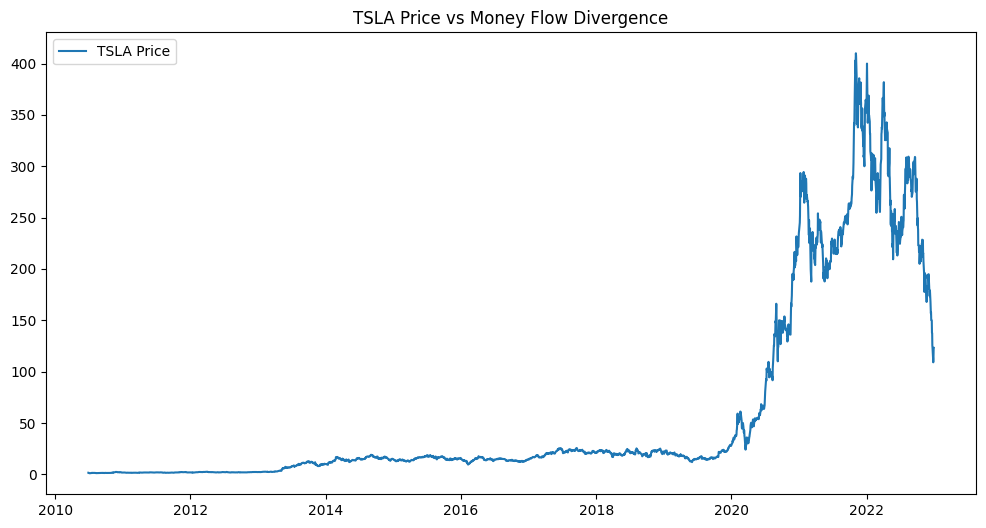

In [33]:

# Function to calculate the M2 Money Flow Divergence
def money_flow_divergence(stock_data, m2_data, period='1M'):
    # Ensure that both stock_data and m2_data have a DatetimeIndex
    stock_data.index = pd.to_datetime(stock_data.index)
    m2_data.index = pd.to_datetime(m2_data.index)
    
    # Resample stock and M2 data to the specified period (e.g., monthly)
    stock_returns = stock_data['Adj Close'].resample(period).ffill().pct_change().dropna()
    m2_growth = m2_data['M2SL'].resample(period).ffill().pct_change().dropna()

    # Compute divergence: M2 Growth - Stock Growth
    divergence = m2_growth - stock_returns
    return divergence

# Function to simulate buy/sell signals based on the divergence
def backtest_strategy(divergence, stock_data, threshold=0.05):
    signals = []
    for date, diff in divergence.items():
        if diff > threshold:
            signals.append((date, 'Buy'))
        else:
            signals.append((date, 'Hold'))
    return signals

# Test on 3 selected stocks (e.g., AAPL, MSFT, TSLA)
stocks = ['AAPL', 'MSFT', 'TSLA']
start_date = '2010-01-01'
end_date = '2023-01-01'

# Download stock price data
stock_data = {stock: yf.download(stock, start=start_date, end=end_date) for stock in stocks}

# Download or load M2 money supply data from a CSV or API
# Ensure M2 data has a 'Date' column and 'M2' value column
# For this example, we're using hypothetical M2 data
m2_data = pd.read_csv('data/M2SL.csv')  # Ensure the M2 data is loaded with a 'Date' and 'M2' column
m2_data['DATE'] = pd.to_datetime(m2_data['DATE'])
m2_data.set_index('DATE', inplace=True)

# Iterate over each stock and backtest the strategy
for stock in stocks:
    print(f"Backtesting on {stock}")
    
    # Get the stock data and M2 divergence
    divergence = money_flow_divergence(stock_data[stock], m2_data)

    # Simulate strategy based on the calculated divergence
    signals = backtest_strategy(divergence, stock_data[stock])
    
    # Display signals and returns
    for signal in signals:
        print(signal)
    
    # Optional: Plot the divergence and stock price
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data[stock]['Adj Close'], label=f'{stock} Price')
    plt.title(f'{stock} Price vs Money Flow Divergence')
    plt.legend()
    plt.show()

### Calculating the Percent Returns (Money Divergence Applied to the Stock Itself)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtesting on AAPL
Total earnings for AAPL from 2015-01-01 to 2020-01-01: 0.28%


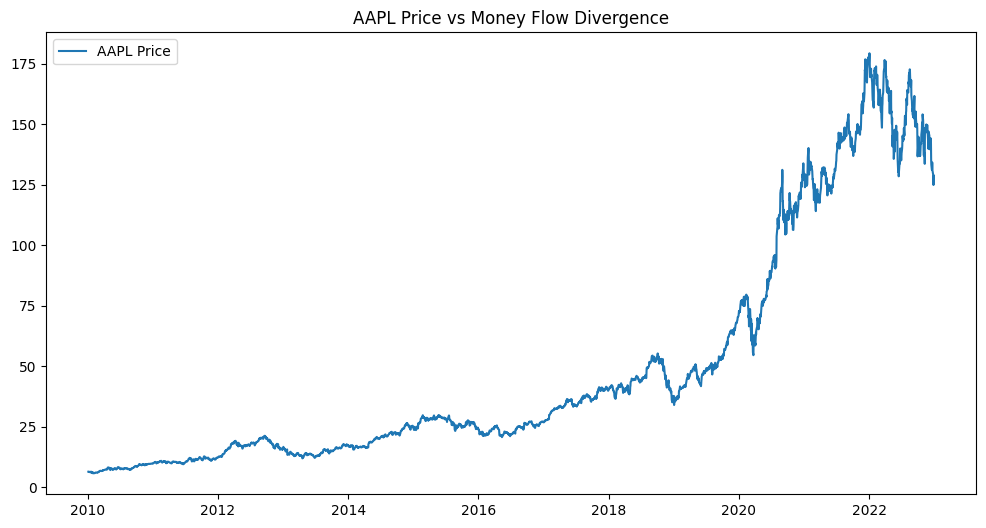

Backtesting on MSFT
Total earnings for MSFT from 2015-01-01 to 2020-01-01: 65.00%


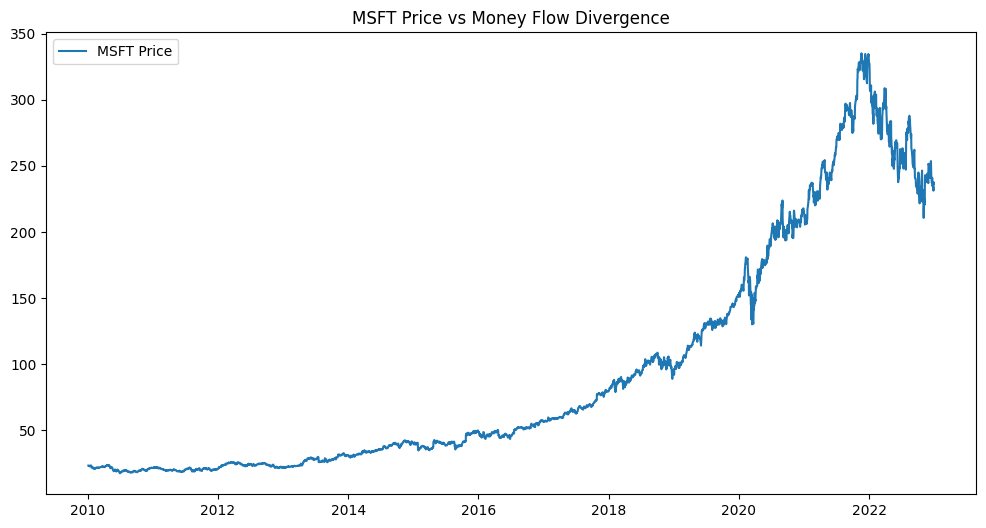

Backtesting on TSLA
Total earnings for TSLA from 2015-01-01 to 2020-01-01: -0.11%


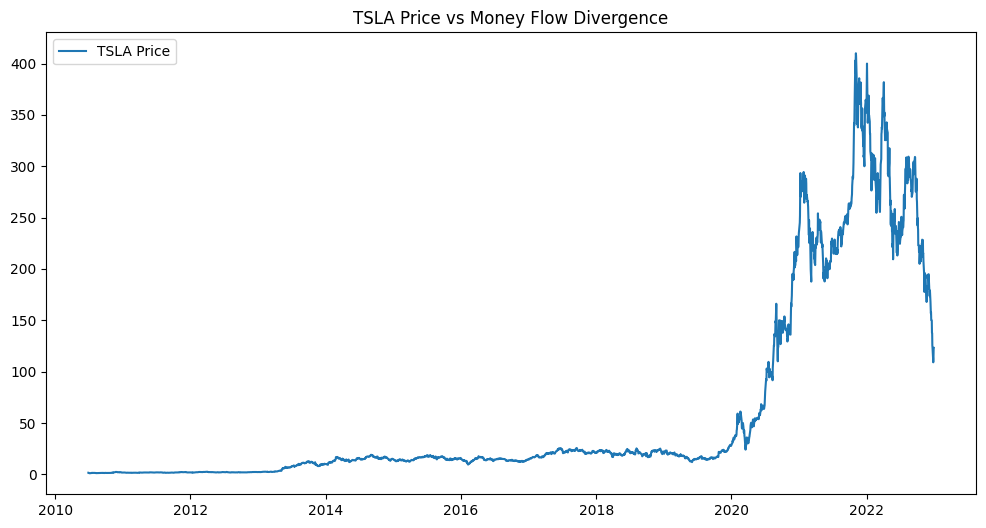

In [40]:
# Function to calculate the M2 Money Flow Divergence
def money_flow_divergence(stock_data, m2_data, period='1M'):
    # Ensure that both stock_data and m2_data have a DatetimeIndex
    stock_data.index = pd.to_datetime(stock_data.index)
    m2_data.index = pd.to_datetime(m2_data.index)
    
    # Resample stock and M2 data to the specified period (e.g., monthly)
    stock_returns = stock_data['Adj Close'].resample(period).ffill().pct_change().dropna()
    m2_growth = m2_data['M2SL'].resample(period).ffill().pct_change().dropna()

    # Compute divergence: M2 Growth - Stock Growth
    divergence = m2_growth - stock_returns
    return divergence

# Function to simulate buy/sell signals based on the divergence
def backtest_strategy(divergence, stock_data, threshold=0.05):
    signals = []
    for date, diff in divergence.items():
        if diff > threshold:
            signals.append((date, 'Buy'))
        else:
            signals.append((date, 'Hold'))
    return signals

# Function to calculate total earnings between two dates
def calculate_total_earnings(stock_data, signals, start_date, end_date):
    total_return = 1  # Start with $1 for simplicity, we will multiply returns
    holding = False
    buy_price = None

    # Ensure we have data for every date by forward filling
    stock_data = stock_data.ffill()

    for date, signal in signals:
        # Only consider dates within the specified range
        if date < pd.to_datetime(start_date) or date > pd.to_datetime(end_date):
            continue

        if signal == 'Buy' and not holding:
            # Check if the date exists in stock_data
            if date in stock_data.index:
                buy_price = stock_data.loc[date]['Adj Close']
                holding = True
        elif holding:
            # Check if the date exists in stock_data
            if date in stock_data.index:
                sell_price = stock_data.loc[date]['Adj Close']
                total_return *= (sell_price / buy_price)
                holding = False  # Reset holding status

    # If still holding at the end date, sell at the last available price
    if holding:
        # Check if end_date exists in stock_data
        if pd.to_datetime(end_date) in stock_data.index:
            final_price = stock_data.loc[pd.to_datetime(end_date)]['Adj Close']
        else:
            final_price = stock_data.iloc[-1]['Adj Close']  # Use the last available price if end_date isn't found
        total_return *= (final_price / buy_price)

    return total_return - 1  # Return the profit/loss percentage

# Test on 3 selected stocks 
stocks = ['AAPL', 'MSFT', 'TSLA']
start_date = '2010-01-01'
end_date = '2023-01-01'
calc_start_date = '2015-01-01'  # Start of the calculation period
calc_end_date = '2020-01-01'    # End of the calculation period

# Download stock price data
stock_data = {stock: yf.download(stock, start=start_date, end=end_date) for stock in stocks}

# Load M2 money supply data from a CSV
m2_data = pd.read_csv('data/M2SL.csv')  # Ensure the M2 data is loaded with a 'Date' and 'M2SL' column
m2_data['DATE'] = pd.to_datetime(m2_data['DATE'])
m2_data.set_index('DATE', inplace=True)

# Iterate over each stock and backtest the strategy
for stock in stocks:
    print(f"Backtesting on {stock}")
    
    # Get the stock data and M2 divergence
    divergence = money_flow_divergence(stock_data[stock], m2_data)

    # Simulate strategy based on the calculated divergence
    signals = backtest_strategy(divergence, stock_data[stock])
    
    # Calculate total earnings between the calculation period
    total_earnings = calculate_total_earnings(stock_data[stock], signals, calc_start_date, calc_end_date)
    
    print(f"Total earnings for {stock} from {calc_start_date} to {calc_end_date}: {total_earnings * 100:.2f}%")
    
    # Optional: Plot the divergence and stock price
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data[stock]['Adj Close'], label=f'{stock} Price')
    plt.title(f'{stock} Price vs Money Flow Divergence')
    plt.legend()
    plt.show()


### Calculating the Percent Returns (Applied from the S&P 500)

In [ ]:
# Function to calculate the M2 Money Flow Divergence
def money_flow_divergence(stock_data, m2_data, period='1M'):
    # Ensure that both stock_data and m2_data have a DatetimeIndex
    stock_data.index = pd.to_datetime(stock_data.index)
    m2_data.index = pd.to_datetime(m2_data.index)
    
    # Resample stock and M2 data to the specified period (e.g., monthly)
    stock_returns = stock_data['Adj Close'].resample(period).ffill().pct_change().dropna()
    m2_growth = m2_data['M2SL'].resample(period).ffill().pct_change().dropna()

    # Compute divergence: M2 Growth - Stock Growth
    divergence = m2_growth - stock_returns
    return divergence

# Function to simulate buy/sell signals based on the divergence
def backtest_strategy(divergence, stock_data, threshold=0.05):
    signals = []
    for date, diff in divergence.items():
        if diff > threshold:
            signals.append((date, 'Buy'))
        else:
            signals.append((date, 'Hold'))
    return signals

# Function to calculate total earnings between two dates
def calculate_total_earnings(stock_data, signals, start_date, end_date):
    total_return = 1  # Start with $1 for simplicity, we will multiply returns
    holding = False
    buy_price = None

    # Ensure we have data for every date by forward filling
    stock_data = stock_data.ffill()

    for date, signal in signals:
        # Only consider dates within the specified range
        if date < pd.to_datetime(start_date) or date > pd.to_datetime(end_date):
            continue

        if signal == 'Buy' and not holding:
            # Check if the date exists in stock_data
            if date in stock_data.index:
                buy_price = stock_data.loc[date]['Adj Close']
                holding = True
        elif holding:
            # Check if the date exists in stock_data
            if date in stock_data.index:
                sell_price = stock_data.loc[date]['Adj Close']
                total_return *= (sell_price / buy_price)
                holding = False  # Reset holding status

    # If still holding at the end date, sell at the last available price
    if holding:
        # Check if end_date exists in stock_data
        if pd.to_datetime(end_date) in stock_data.index:
            final_price = stock_data.loc[pd.to_datetime(end_date)]['Adj Close']
        else:
            final_price = stock_data.iloc[-1]['Adj Close']  # Use the last available price if end_date isn't found
        total_return *= (final_price / buy_price)

    return total_return - 1  # Return the profit/loss percentage

# Test on 3 selected stocks 
stocks = ['AAPL', 'MSFT', 'TSLA']
start_date = '2010-01-01'
end_date = '2023-01-01'
calc_start_date = '2015-01-01'  # Start of the calculation period
calc_end_date = '2020-01-01'    # End of the calculation period

# Download stock price data
stock_data = {stock: yf.download(stock, start=start_date, end=end_date) for stock in stocks}

# Load M2 money supply data from a CSV
m2_data = pd.read_csv('data/M2SL.csv')  # Ensure the M2 data is loaded with a 'Date' and 'M2SL' column
m2_data['DATE'] = pd.to_datetime(m2_data['DATE'])
m2_data.set_index('DATE', inplace=True)

# Iterate over each stock and backtest the strategy
for stock in stocks:
    print(f"Backtesting on {stock}")
    
    # Get the stock data and M2 divergence
    divergence = money_flow_divergence(stock_data[stock], m2_data)

    # Simulate strategy based on the calculated divergence
    signals = backtest_strategy(divergence, stock_data[stock])
    
    # Calculate total earnings between the calculation period
    total_earnings = calculate_total_earnings(stock_data[stock], signals, calc_start_date, calc_end_date)
    
    print(f"Total earnings for {stock} from {calc_start_date} to {calc_end_date}: {total_earnings * 100:.2f}%")
    
    # Optional: Plot the divergence and stock price
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data[stock]['Adj Close'], label=f'{stock} Price')
    plt.title(f'{stock} Price vs Money Flow Divergence')
    plt.legend()
    plt.show()